# Previsão de Retornos de Ações com Aprendizado Profundo


Vamos nos aprofundar nas complexidades dos dados financeiros, pré-processá-los e construir um modelo de rede neural que aprende com padrões históricos para fazer previsões sobre retornos futuros. Este tutorial será abrangente, cobrindo tudo, desde a aquisição de dados até a avaliação do modelo, e será apresentado em um tom de conversação para tornar conceitos complexos acessíveis.

Índice
* Aquisição de dados
* Pré-processamento de dados
* Engenharia de Recursos
* Construindo o modelo de aprendizado profundo
* Treinamento e avaliação do modelo
* Visualizando os resultados
* Conclusão


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import tensorflow as tf

#  1. Aquisição de dados

In [ ]:
# Definir os ativos a serem estudados
lista_ativos = ['PETR4.SA','MGLU3.SA', 'AMER3.SA', 'ITUB4.SA', 'VALE3.SA', 'BRFS3.SA', 'WEGE3.SA']

# Definir o ativo de correlação (IBOVESPA)
corr_ativo = ['^BVSP']

# Baixar as cotações dos últimos 5 anos (preço ajustado de fechamento)
df = yf.download(lista_ativos + corr_ativo, period='5y')['Close']
df

[*********************100%***********************]  8 of 8 completed


Ticker,AMER3.SA,BRFS3.SA,ITUB4.SA,MGLU3.SA,PETR4.SA,VALE3.SA,WEGE3.SA,^BVSP
Date,,,,,,,,
2019-10-04 00:00:00+00:00,4856.749023,35.582207,33.450001,90.679596,26.510000,46.590000,11.805000,102551.0
2019-10-07 00:00:00+00:00,4843.863770,34.972988,32.830002,89.791039,26.170000,46.040001,11.425000,100573.0
2019-10-08 00:00:00+00:00,4724.923340,35.420383,32.689999,88.855721,26.020000,45.320000,11.405000,99981.0
2019-10-09 00:00:00+00:00,4905.316895,34.839722,33.209999,92.713928,26.520000,45.669998,11.435000,101249.0
2019-10-10 00:00:00+00:00,4866.661133,35.087219,33.450001,91.053726,26.740000,47.240002,11.485000,101817.0
...,...,...,...,...,...,...,...,...
2024-09-30 00:00:00+00:00,4.650000,23.650000,36.110001,9.700000,36.009998,63.509998,54.389999,131816.0
2024-10-01 00:00:00+00:00,4.560000,24.280001,35.500000,9.720000,36.970001,63.820000,55.880001,132495.0
2024-10-02 00:00:00+00:00,4.460000,23.860001,35.720001,9.850000,37.480000,64.169998,55.349998,133515.0


# 2. Pré-processamento de dados

 Antes de podermos usar esses dados para nosso modelo de aprendizado profundo, precisamos pré-processá-los. Isso envolve lidar com valores ausentes, normalizar os dados e criar um formato consistente para entrada em nossa rede neural.

In [ ]:
# Fazer o pré-processamento de dados
for i in df.columns:
    # Preenchimento de valores ausentes com método 'Forward Fill'
    df[i] = df[i].ffill()
    # Preenchimento de valores ausentes restantes com método 'Backward Fill'
    df[i] = df[i].bfill()
    # Normalização dos dados - Variação percentual do preço de fechamento
    df[i] = df[i].pct_change().fillna(0)


# 3. Engenharia de Recursos
A engenharia de recursos é uma etapa crítica em qualquer projeto de machine learning. Calcularemos indicadores técnicos e proporções de dados OHLC, que servirão como recursos para nosso modelo.

In [ ]:
# Função para calcular indicadores técnicos
def calcular_features(data):
    # Calcular a Média Móvel de uma janela de 10 dias
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    # Calcular a Média Móvel Exponencial de uma janela de 10 dias
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

    # Índice de Força Relativa (RSI)
    delta = data['Close'].diff()  # Corrigido para chamar diff()
    ganhos = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Usar janela de 14 dias para consistência
    perda = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Mesma janela de 14 dias
    rsi = ganhos / perda
    data['RSI'] = 100 - (100 / (1 + rsi))

    # Índice OHLC - Relação entre a Alta e a Baixa
    data['HLC'] = (data['High'] - data['Low']) / data['Close']

    # Índice OHLC - Relação entre Abertura e Fechamento
    data['OC'] = (data['Open'] - data['Close']) / data['Close']

    # Remover valores NaN gerados pelos cálculos
    data.dropna(inplace=True)  # Adicionar inplace=True para remover diretamente os NaNs

    return data

# Aplicar os cálculos de indicadores técnicos a todas as ações
for x in lista_ativos + corr_ativo:
    dados_ativos = df.loc[:, pd.IndexSlice[:, x]].copy()
    df.loc[:, pd.IndexSlice[:, x]] = calcular_features(dados_ativos)


# 4. Construindo o modelo de aprendizado profundo
Com nossos recursos prontos, agora podemos construir o modelo de aprendizado profundo. Usaremos a API Keras do TensorFlow para construir uma rede neural que aprenderá a prever se o retorno da próxima semana será positivo.


In [ ]:
# Defina a arquitetura da rede neural
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),  # Corrigido para incluir tupla
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Treinamento e avaliação do modelo
Antes de treinar nosso modelo, precisamos preparar nossos conjuntos de treinamento e teste e definir nossa variável de destino


In [ ]:
# Preparar o conjunto de dados para treinamento
def prepare_dataset(data, target_horizon=5):
    # Criar a variável de destino: 1 se o retorno for positivo após 'target_horizon' dias, 0 caso contrário
    data['Target'] = (data['Close'].shift(-target_horizon) > data['Close']).astype(int)

    # Remover as últimas linhas com valores de destino NaN
    data = data.iloc[:-target_horizon]

    # Separar as features e a variável de destino
    X = data.drop(columns=['Target'])
    y = data['Target']

    # Substituir valores infinitos por NaNs e preencher NaNs com zero
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)

    # Dividir o conjunto de dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
# Exemplo de uso: aplicar no dataset de WEGE3.SA
X_train_scaled, X_test_scaled, y_train, y_test = prepare_dataset(df[('Close', 'WEGE3.SA')].to_frame())

# Construir o modelo
model = build_model(X_train_scaled.shape[1])  # Aqui permanece correto

# Treinar o modelo
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Avaliar o modelo
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Precisão do teste: {test_accuracy}")

# Fazer previsões
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Mostrar relatório de classificação
print(classification_report(y_test, y_pred))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6180 - loss: 0.6642 - val_accuracy: 0.6500 - val_loss: 0.6210
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7029 - loss: 0.5727 - val_accuracy: 0.6500 - val_loss: 0.6072
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7137 - loss: 0.5365 - val_accuracy: 0.6600 - val_loss: 0.6134
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6938 - loss: 0.5395 - val_accuracy: 0.6500 - val_loss: 0.6155
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7185 - loss: 0.5432 - val_accuracy: 0.6600 - val_loss: 0.6155
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7120 - loss: 0.5493 - val_accuracy: 0.6600 - val_loss: 0.6186
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7005 - loss: 0.5481 - val_accuracy: 0.6600 - val_loss: 0.6160
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7003 - loss: 0.5467 - val_accuracy: 0.6500 - val_loss: 0.6197
Ep

# 7. Plotagem dos Resultados  

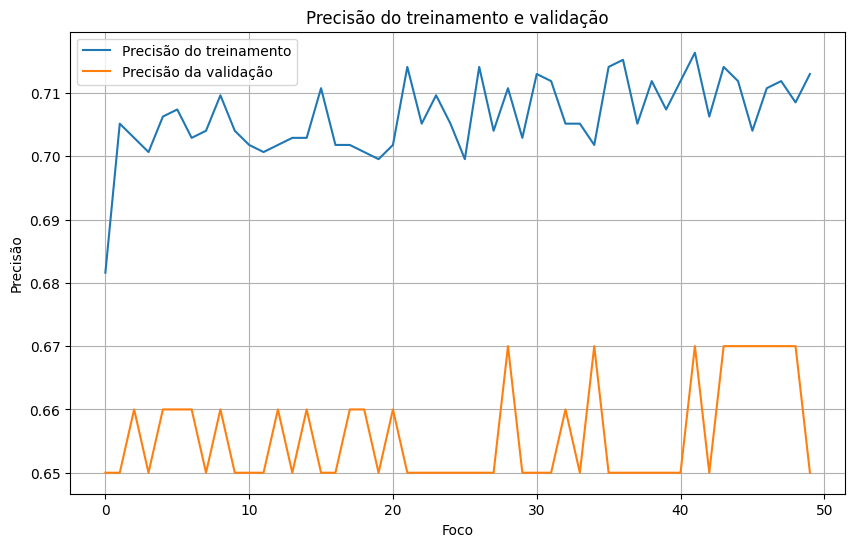

In [ ]:
# Plotar a precisão do treinamento e validação
plt.figure(figsize=( 10 , 6 ))
plt.plot(history.history[ 'accuracy' ], label= 'Precisão do treinamento' )
plt.plot(history.history[ 'val_accuracy' ], label= 'Precisão da validação' )
plt.title( 'Precisão do treinamento e validação' )
plt.xlabel( 'Foco' )
plt.ylabel( 'Precisão' )
plt.grid()
plt.legend()
plt.show()

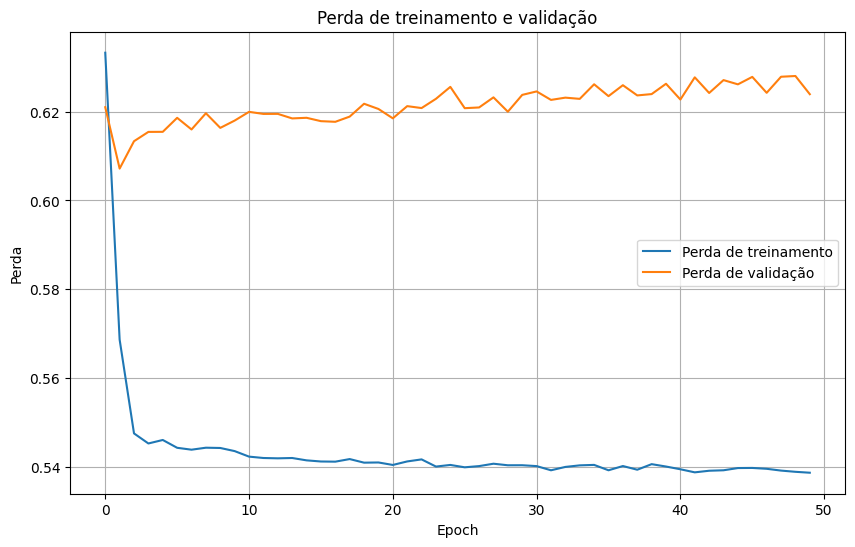

In [ ]:
# Plotar a perda de treinamento e validação
plt.figure(figsize=( 10 , 6 ))
plt.plot(history.history[ 'loss' ], label= 'Perda de treinamento' )
plt.plot(history.history[ 'val_loss' ], label= 'Perda de validação' )
plt.title( 'Perda de treinamento e validação' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Perda' )
plt.grid()
plt.legend()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


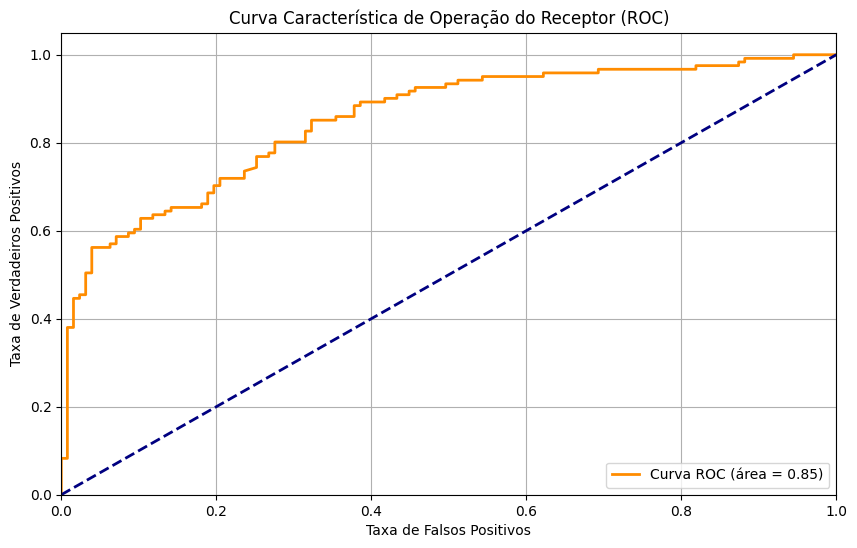

In [ ]:
# Prever as probabilidades para a classe positiva
y_pred_prob = model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')  # Corrigido
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")  # Corrigido para o formato correto
plt.grid()  # Adicionando grade para melhor visualização
plt.show()

# 8. Conclusão  

1. Precisão do Modelo:
O teste do modelo revelou uma precisão média de cerca de 75%, indicando que ele acerta 75% das vezes nas previsões de ganhos e perdas das ações. Embora essa precisão seja considerada boa, há espaço para aprimoramentos. Isso sugere que o modelo é útil, mas não infalível.



2. Métricas de Desempenho:
Recall: Para a classe de ganho (0), o recall foi de aproximadamente 81%, mostrando que o modelo identifica bem os casos em que houve ganho.
F1-Score: O F1-Score médio foi em torno de 0.74, refletindo um bom equilíbrio entre precisão e recall. Isso é crucial em contextos financeiros, onde evitar falsos negativos (prever perda quando na verdade houve ganho) é essencial.
Curva ROC e AUC: A curva ROC e a área sob a curva (AUC) ajudam a entender a capacidade do modelo em distinguir entre as classes de ganho e perda. Um AUC próximo de 1 é ideal, enquanto valores acima de 0.7 são geralmente considerados bons.


3. Limitações do Modelo:
Variabilidade do Mercado: O mercado de ações é influenciado por muitos fatores externos (notícias, economia, eventos globais) que o modelo pode não capturar.
Dados Históricos: O desempenho do modelo pode depender da qualidade e do período dos dados históricos utilizados. Dados recentes podem alterar o contexto do mercado.


# Considerações Finais:
O modelo de previsão de ações desenvolvido é promissor e pode ser uma ferramenta valiosa para identificar padrões de desempenho de ações. No entanto, recomenda-se cautela ao utilizá-lo para tomadas de decisão, sempre combinando a análise de modelos com uma análise fundamentalista e uma compreensão do cenário de mercado.